# Lab 4: Advanced Neural Nets
### Шевченко Юлія, ФІ-31мн

### Lab Task:

1. _**Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір)**_. Вирішити завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  
2. Провести експерименти з моделями бібліотеки HF Transformers за допомогою (наприклад) Pipeline модуля.
3. _**Завдання щодо генерації або стилізації зображень (на вибір)**_. Вирішити завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE).

In [99]:
# All the imports for the task
import os

import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten
from tensorflow.keras.models import Sequential

### Task 3

In [2]:
# df = pd.read_csv('../Lab_4/list.csv')
# output_folder = '../Lab_4/doodles_images'
# os.makedirs(output_folder, exist_ok=True)
# 
# for index, row in df.iterrows():
#     image_url = row['high_res_url']
# 
#     if pd.notna(image_url) and isinstance(image_url, str):
#         if not image_url.startswith(('http://', 'https://')):
#             image_url = urljoin('https:', image_url)
# 
#         image_filename = os.path.join(output_folder, f"{row['year']}_{row['month']}_{row['day']}_{row['name']}.jpg")
# 
#         try:
#             response = requests.get(image_url, stream=True)
#             with open(image_filename, 'wb') as file:
#                 for chunk in response.iter_content(chunk_size=1024):
#                     if chunk:
#                         file.write(chunk)
#         except Exception as e:
#             print('Error, while downloading {}: {}'.format(image_url, e))
#     else:
#         print('Error, invalid URL:'.format(image_url))
# 
# print('Images were downloaded to {}'.format(output_folder))

Images were downloaded to ../Lab_4/doodles_images


In [94]:
input_folder = "../Lab_4/doodles_images"
output_folder = "../Lab_4/doodles_images_resized"
target_size = (128, 128)

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Loop through each file in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        # Open the image
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)

        # Resize the image
        resized_img = img.resize(target_size)

        # Convert the image to RGB mode
        rgb_img = resized_img.convert('RGB')

        # Save the resized image to the output folder
        output_path = os.path.join(output_folder, filename)
        rgb_img.save(output_path)

print("Resizing complete.")

D:\Study\Sem_9\DA\DataAnalysis\venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Resizing complete.


In [122]:
#Importing data
data_path = "../Lab_4/doodles_images_resized"
batch_s = 128

#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode=None, image_size=(128, 128), batch_size=batch_s)

Found 5848 files belonging to 1 classes.


In [123]:
# Normalize the data
data = data.map(lambda x: x / 255.0)

In [124]:
latent_dim = 100
g_resolution=2

# Building a Generator
generator = Sequential()

# Input layer
generator.add(Dense(4 * 4 * 512, input_dim=latent_dim))
generator.add(Reshape((4, 4, 512)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))

# Upsampling layers
generator.add(UpSampling2D())
generator.add(Conv2D(256, kernel_size=3, padding="same"))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))

generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size=3, padding="same"))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))

generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=3, padding="same"))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))

generator.add(UpSampling2D())
generator.add(Conv2D(32, kernel_size=3, padding="same"))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))

# Output layer
generator.add(Conv2D(3, kernel_size=3, padding="same", activation="tanh"))

# Upsampling to achieve the desired output resolution
generator.add(UpSampling2D(size=(2, 2)))

generator.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 8192)              827392    
                                                                 
 reshape_18 (Reshape)        (None, 4, 4, 512)         0         
                                                                 
 batch_normalization_35 (Ba  (None, 4, 4, 512)         2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_82 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 up_sampling2d_23 (UpSampli  (None, 8, 8, 512)         0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 8, 8, 256)       

(-0.5, 127.5, 127.5, -0.5)

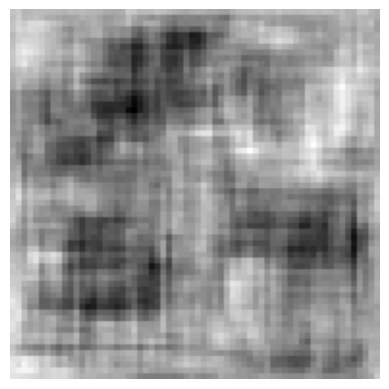

In [125]:
# Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
generated_doodle = generator(seed, training=False)
# Plotting the image output of generator without training 
plt.imshow(generated_doodle[0, :, :, 0])
plt.axis("off")

In [126]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(128, 128, 3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu_87 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 dropout_30 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_78 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 zero_padding2d_3 (ZeroPadd  (None, 33, 33, 64)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_40 (Ba  (None, 33, 33, 64)        256       
 tchNormalization)                                   

In [127]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [128]:
#Defining the number of epochs
epochs = 20
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

Epoch 1/20
46/46 [==============================] - 146s 3s/step - d_loss: 0.4749 - g_loss: 1.4360
Epoch 2/20
46/46 [==============================] - 140s 3s/step - d_loss: 0.3636 - g_loss: 1.9310
Epoch 3/20
46/46 [==============================] - 140s 3s/step - d_loss: 0.1660 - g_loss: 2.9587
Epoch 4/20
46/46 [==============================] - 144s 3s/step - d_loss: 0.0632 - g_loss: 4.5512
Epoch 5/20
46/46 [==============================] - 140s 3s/step - d_loss: 0.0449 - g_loss: 5.6761
Epoch 6/20
46/46 [==============================] - 140s 3s/step - d_loss: 0.0353 - g_loss: 6.4836
Epoch 7/20
46/46 [==============================] - 140s 3s/step - d_loss: 0.0302 - g_loss: 7.4561
Epoch 8/20
46/46 [==============================] - 140s 3s/step - d_loss: 0.0133 - g_loss: 8.5608
Epoch 9/20
46/46 [==============================] - 140s 3s/step - d_loss: 0.0020 - g_loss: 9.8406
Epoch 10/20
46/46 [==============================] - 140s 3s/step - d_loss: -0.0119 - g_loss: 11.6812
Epoch 1

In [129]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def img_generator():
    generated_images = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            generated_images.append(img)
            img.save("Potraits{:02d}.png".format(i)) 
    return 

#Generating images
Images = img_generator()